Attacking PPD trained on CIFAR-10
===
This Notebook loads trained PPD models on CIFAR-10 dataset, Ensembles them and generates adversarial examples using different attacks.

The models are loaded from saved_models >> cifar10dense

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from copy import deepcopy

In [2]:
# This block is needed because before loading the trained models, the graph should be loaded with the same
# structure as it was trained.

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import functools
from cleverhans.model import Model


# ______________________________________ content of my local utils_tf.py _______________________________
def fftshift(inputs):
    """
    Calculates and returns fftshift of the inputs tensor along second and third axes.
    :param inputs: Tensor with shape (None, ., ., .)
    :return: a Tensor which is fftshift of inputs along second and third axes with same dtype and shape
    """
    axes = range(1, len(inputs.shape) - 1)
    for k in axes:
        n = inputs.shape[k]
        p2 = (n + 1) // 2
        my_list = tf.concat((tf.range(p2, n), tf.range(p2)), axis=0)
        inputs = tf.gather(inputs, my_list, axis=k)
    return inputs


def pixel2phase(inputs):
    """
    convert the inputs images to the phase domain along each channel.
    :param inputs: Tensor with shape (None, height, width, channels)
    :return: Tensor with same shape and dtype as inputs
    """
    inputs_dtype = inputs.dtype
    dtype = tf.complex64
    inputs = tf.cast(inputs, dtype=dtype)
    input_f = fftshift(tf.transpose(tf.fft2d(tf.transpose(inputs, perm=[0, 3, 1, 2])), perm=[0, 2, 3, 1]))
    input_f = tf.where(tf.less(tf.abs(input_f), 1e-5), tf.zeros(tf.shape(input_f), dtype=dtype), input_f)
    return tf.cast(tf.angle(input_f), dtype=inputs_dtype)
#_______________________________________________________________________________________________________


#________________________________________content of my local model_structure.py ________________________
class ModelDense(Model):
    def __init__(self, scope, nb_classes, reg, **kwargs):
        del kwargs
        Model.__init__(self, scope, nb_classes, locals())
        self.reg = reg

    def fprop(self, x, **kwargs):
        del kwargs
        my_conv = functools.partial(tf.layers.dense, activation=tf.nn.relu,
                                    kernel_regularizer=tf.contrib.layers.l2_regularizer(self.reg),
                                    kernel_initializer=HeReLuNormalInitializer,
                                    )
        with tf.variable_scope(self.scope, reuse=tf.AUTO_REUSE):
            y = pixel2phase(x)
            y = tf.layers.flatten(y)
            y = my_conv(y, 800)
            y = my_conv(y, 300)

            logits = tf.layers.dense(y, self.nb_classes,
                                     kernel_regularizer=tf.contrib.layers.l2_regularizer(self.reg),
                                     kernel_initializer=HeReLuNormalInitializer)
            return {self.O_LOGITS: logits,
                    self.O_PROBS: tf.nn.softmax(logits=logits)}


class HeReLuNormalInitializer(tf.initializers.random_normal):
    def __init__(self, dtype=tf.float32):
        self.dtype = tf.as_dtype(dtype)

    def get_config(self):
        return dict(dtype=self.dtype.name)

    def __call__(self, shape, dtype=None, partition_info=None):
        del partition_info
        dtype = self.dtype if dtype is None else dtype
        std = tf.rsqrt(tf.cast(tf.reduce_prod(shape[:-1]), tf.float32) + 1e-7)
        return tf.random_normal(shape, stddev=std, dtype=dtype)

In [3]:
# _________________________________________ content of utils.py ______________________________
def _permute_index(l, seed):
    """
    Creates a permutation of np.array([0, ..., l-1]) and its inverse
    :param l: length of the array to permute
    :param seed: permutation seed
    :return: (s, s_inverse) where s is permutation of np.array([0, ..., l-1]) and s_inverse is its inverse
    """
    st0 = np.random.get_state()
    s = np.arange(l)
    np.random.seed(seed)
    np.random.shuffle(s)
    s_inverse = np.argsort(s)
    np.random.set_state(st0)
    return s, s_inverse


def permute(data, seed):
    """
    Permutes images in the data with given seed for each channel.
    :param data: numpy array with shape (nb_images, img_rows, img_cols, nb_channels)
    :param seed: permutation seed. If seed=None returns data without permutation
    :return: numpy array with shape (nb_images, img_rows, img_cols, nb_channels) of permuted images
    """
    """
    Permutes images in the data with given seed. If seed=None, returns data without permutation.
    Assumes data has shape (nb_images, img_rows, img_cols, nb_channels)
    """
    nb_images, img_rows, img_cols, nb_channels = data.shape
    if seed is None:
        return data
    l = img_rows * img_cols  # length of the permutation array
    s, _ = _permute_index(l, seed)
    output = np.zeros(data.shape)
    for ch in range(nb_channels):
        output[:, :, :, ch] = data[:, :, :, ch].reshape(-1, l)[:, s].reshape(-1, img_rows, img_cols)
    return output


def ipermute(data, seed):
    """
    inverse of permute
    :param data: numpy array with shape (nb_images, img_rows, img_cols, nb_channels)
    :param seed:  permutation seed. If seed=None returns data without permutation
    :return: numpy array with shape (nb_images, img_rows, img_cols, nb_channels) of inverse permuted images
    """
    nb_images, img_rows, img_cols, nb_channels = data.shape
    if seed is None:
        return data
    l = img_rows * img_cols  # length of the permutation array
    _, s_inverse = _permute_index(l, seed)
    output = np.zeros(data.shape)
    for ch in range(nb_channels):
        output[:, :, :, ch] = data[:, :, :, ch].reshape(-1, l)[:, s_inverse].reshape(-1, img_rows, img_cols)
    return output

In [4]:
def log_attack(attack_name, adv_x, perturbation_strength, attack_params):
    """
    saves adv_x with name perturbaton_strength in subfolder with attack_name
    """
    directory = os.path.join('Attack Logs', attack_name)
    if not os.path.exists(directory):
        os.makedirs(directory)

    import json
    with open(os.path.join(directory, 'params' + str(perturbation_strength) + '.txt'), 'w') as file:
        file.write(json.dumps(attack_params)) # use `json.loads` to do the reverse
    np.save(os.path.join(directory, str(perturbation_strength)), adv_x)


def _read_attack(attack_name, perturbation_strength):
    """
    loads adv_x with name perturbaton_strength in subfolder with attack_name
    :param attack_name: string of attack name used for folder to save
    :param perturbation_strength: a float or string of attack file
    """
    filename = os.path.join('Attack Logs', attack_name, str(perturbation_strength) + '.npy')
    return np.load(filename)

def read_attack(attack_name):
    directory = os.path.join('Attack Logs', attack_name)
    out = dict()
    for filename in os.listdir(directory):
        if filename.endswith('.npy'):
            path_to_file = os.path.join(directory, filename)
            out[np.float(os.path.splitext(filename)[0])] = np.load(path_to_file)
    return out

In [5]:
def measure_perturbation(x, adv_x, order):
    """
    average perturbation between x and adv_x. Note that each image is converted to
    a vector of size (img_rows*img_cols*nb_channels) and then norm is calculated.
    :param x: numpy array with shape (nb_images, img_rows, img_cols, nb_channels)
    :param adv_x: numpy array with same shape as x
    :param order: order of the norm (mimics numpy) possible values are np.inf, 1 or 2
    :return: a scalar denoting perturbation between x and adv_x averaged over images.
    """
    nb_images, _, _, _ = x.shape
    dev = (x-adv_x).reshape(nb_images, -1)
    dev_norms = np.linalg.norm(dev, order, axis=1)
    return np.mean(dev_norms)

def random_perturb(x, perturbation_strength, order):
    """
    randomly perturbes pixels of x with perturbation_strength such that 
    measure_perturbation(x, random_perturb(x, perturbation_strength, order), order) = perturbation_strength.
    For order=np.inf each pixel is perturbed with either -perturbation_strenth or perturbation_strength.
    For order = 1 and order = 2, images of the pixel are perturbed with a uniform random noise with mean zero.
    :param x: numpy array with shape (nb_images, img_rows, img_cols, nb_channels)
    :param perturbation_strength: a scalar that is strength of noise.
    :param order: order of the norm (mimics numpy) possible values are np.inf, 1 or 2
    :return: numpy array with same shape as x which denotes random perturbation of pixels of x with perturbation_strength
    """
    nb_images, img_rows, img_cols, nb_channels = x.shape
    if order == np.inf:
        dev = (np.random.randint(0, 2, size=nb_images*img_rows*img_cols*nb_channels) * 2 * perturbation_strength - perturbation_strength)
    elif order == 1:
        tmp = np.random.rand(nb_images, img_rows*img_cols*nb_channels) - 0.5
        coef = perturbation_strength / np.sum(np.abs(tmp), axis=1)
        dev = tmp * np.expand_dims(coef, axis=1)
    elif order == 2:
        tmp = np.random.rand(nb_images, img_rows*img_cols*nb_channels) - 0.5
        coef = perturbation_strength / np.linalg.norm(tmp, 2, axis=1)
        dev = tmp * np.expand_dims(coef, axis=1)
    else:
        raise(ValueError('order should be np.inf, 1 or 2'))
    return x + dev.reshape(x.shape) 

In [6]:
def log_plot_data(attack_name, header, arr):
    """
    concatenates numpy arrays in arr and saves them as 'plot_data.csv'.
    :param attack_name: string of attack name (the folder in which data is to be logged)
    :param header: list of strings denoting header name for element of arr
    :param arr: list of numpy arrays to be logged. For example: [strength, adv_acc, ...]
    """
    import pandas as pd
    directory = os.path.join('Attack Logs', attack_name)
    tmp = np.concatenate(tuple([np.array(a).reshape(-1, 1) for a in arr]), axis=1)
    df = pd.DataFrame(tmp, columns=header)
    df.to_csv(os.path.join(directory, 'plot_data'), index=False)
    
def load_plot_data(attack_name):
    """
    reads data saved with log_plot_data
    :param attack_name: string of attack name (the folder to read from)
    :return: a pandas dataFrame containing plot data.
    """
    import pandas as pd
    path = os.path.join('Attack Logs', attack_name, 'plot_data')
    df = pd.read_csv(path)
    return df

In [7]:
from cleverhans.utils_tf import tf_model_load
class Ensemble(object):
    
    def __init__(self, seeds, directory, model_class, **kwargs):
        
        self.img_rows = kwargs.get('img_rows', 28)
        self.img_cols = kwargs.get('img_cols', 28)
        self.nb_channels = kwargs.get('nb_channels', 1)
        self.nb_classes = kwargs.get('nb_classes', 10)
        self.reg = kwargs.get('reg', 5e-3)
        self.scope = kwargs.get('scope', 'model1')
        
        self.seeds = seeds
        self.directory = directory
        self.model_class = model_class
        self.sessions_dict, self.models_dict, self.placeholders_dict = self.load_models()
                
    def load_models(self):
        sessions_dict = dict()
        models_dict = dict()
        placeholders_dict = dict()
        for seed in self.seeds:
            sess = tf.Session(graph=tf.Graph())
            with sess.graph.as_default():
                # ____________________ defining the model graph ________________________
                x = tf.placeholder(tf.float32, shape=(None, self.img_rows, self.img_cols, self.nb_channels))
                model = self.model_class(scope=self.scope, nb_classes=self.nb_classes, reg=self.reg)
                preds = model.get_logits(x)
                # ______________________________________________________________________
                
                model_path = os.path.join(self.directory, str(seed), 'cifar10')
                if os.path.exists(model_path  + ".meta"):
                    tf_model_load(sess, model_path)
                sessions_dict[seed] = sess
                models_dict[seed] = model
                placeholders_dict[seed] = x
        return sessions_dict, models_dict, placeholders_dict
    
    def predict(self, unpermuted_pixel_data, seeds=None):
        if seeds is None:
            seeds = self.seeds
        total_pred = 0
        for seed in seeds:
            sess = self.sessions_dict[seed]
            with sess.graph.as_default():
                model = self.models_dict[seed]
                x = self.placeholders_dict[seed]
                preds = model.get_probs(x)
                total_pred += sess.run(preds, feed_dict={x: permute(unpermuted_pixel_data, seed=seed)})
        return total_pred/len(seeds)
                
    def get_model(self, seed):
        return self.models_dict[seed], self.sessions_dict[seed], self.placeholders_dict[seed]
    
    def accuracy_plot(self, unpermuted_pixel_data, true_labels, seeds=None):
        if seeds is None:
            seeds = self.seeds
        out = []
        total_pred = 0
        for seed in seeds:
            sess = self.sessions_dict[seed]
            with sess.graph.as_default():
                model = self.models_dict[seed]
                x = self.placeholders_dict[seed]
                preds = model.get_probs(x)
                total_pred += sess.run(preds, feed_dict={x: permute(unpermuted_pixel_data, seed=seed)})
                p = total_pred/(len(out) + 1)
                out.append(np.mean(np.equal(np.argmax(p, axis=1), np.argmax(true_labels, axis=1))))
        return out
        
    
    def accuracy(self, unpermuted_pixel_data, true_labels, seeds=None):
        return np.mean(np.equal(np.argmax(self.predict(unpermuted_pixel_data, seeds=seeds), axis=1), np.argmax(true_labels, axis=1)))
        
                
    

In [8]:
dataset_params = {
    'img_rows': 32,
    'img_cols': 32,
    'nb_channels': 3,
    'nb_classes': 10
}

model_params = {
    'scope': 'model1',
    'reg': 5e-2
}

eval_params = {
    'batch_size': 128
}

ensemble_params = deepcopy(dataset_params)
ensemble_params.update(model_params)

In [9]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

y_train = tf.keras.utils.to_categorical(y_train, dataset_params['nb_classes'])
y_test = tf.keras.utils.to_categorical(y_test, dataset_params['nb_classes'])
print("x_train shape =", x_train.shape)
print("y_train shape =", y_train.shape)
print ("x_test shape =", x_test.shape)

x_train shape = (50000, 32, 32, 3)
y_train shape = (50000, 10)
x_test shape = (10000, 32, 32, 3)


In [10]:
seeds = range(100, 151) # before loading models they should be trained and saved using main_cifar10.py
directory = os.path.join('saved_models', 'cifar10dense')
ensemble = Ensemble(seeds=seeds, directory=directory, model_class=ModelDense, **ensemble_params)

INFO:tensorflow:Restoring parameters from saved_models/cifar10dense/100/cifar10
INFO:tensorflow:Restoring parameters from saved_models/cifar10dense/101/cifar10
INFO:tensorflow:Restoring parameters from saved_models/cifar10dense/102/cifar10
INFO:tensorflow:Restoring parameters from saved_models/cifar10dense/103/cifar10
INFO:tensorflow:Restoring parameters from saved_models/cifar10dense/104/cifar10
INFO:tensorflow:Restoring parameters from saved_models/cifar10dense/105/cifar10
INFO:tensorflow:Restoring parameters from saved_models/cifar10dense/106/cifar10
INFO:tensorflow:Restoring parameters from saved_models/cifar10dense/107/cifar10
INFO:tensorflow:Restoring parameters from saved_models/cifar10dense/108/cifar10
INFO:tensorflow:Restoring parameters from saved_models/cifar10dense/109/cifar10
INFO:tensorflow:Restoring parameters from saved_models/cifar10dense/110/cifar10
INFO:tensorflow:Restoring parameters from saved_models/cifar10dense/111/cifar10
INFO:tensorflow:Restoring parameters fro

In [9]:
out = ensemble.accuracy_plot(x_test, y_test)
# acc = ensemble.accuracy(x_test, y_test, seeds=range(100, 150)) # if seeds=None, accuracy on all the ensembled models is provided. if a list
# of models is provided as seeds (for example seeds=[100, 101, 102]) ensemble of accuracy on models in seeds is provided.

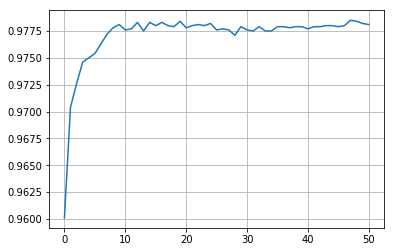

In [11]:
plt.plot(out)
plt.grid()

FGSM
===

In [11]:
# performing FGSM attack
from cleverhans.attacks import FastGradientMethod
from cleverhans.utils_tf import model_eval

seed = 100 # model for which attack is performed
model, sess, x = ensemble.get_model(seed)

nb_attacked_images = 10000
fgsm_params = {
        'eps': 6.444,
        'ord': 2
        }
print('Attacking model {0} ...'.format(seed))
fgsm = FastGradientMethod(model, sess=sess)
with sess.graph.as_default():
    y = tf.placeholder(tf.float32, shape=(None, dataset_params['nb_classes']))
    adv_x_fgsm = ipermute(fgsm.generate_np(permute(x_test[0:nb_attacked_images], seed), **fgsm_params), seed)
    preds = model.get_logits(x)
adv_acc = model_eval(sess, x, y, preds, permute(adv_x_fgsm, seed=seed), y_test[0:nb_attacked_images], args=eval_params)
print('Accuracy on model {0}:'.format(seed), adv_acc)

Attacking model 100 ...
Accuracy on model 100: 0.4321


In [12]:
order = 2
perturbation_strength = measure_perturbation(x_test[0:nb_attacked_images], adv_x_fgsm, order=order)
print('Average l_{0} norm perturbation of adversarial examples:'.format(order), perturbation_strength)

Average l_2 norm perturbation of adversarial examples: 6.4439998702978665


In [13]:
log_attack(attack_name='fgml2', adv_x=adv_x_fgsm, perturbation_strength=perturbation_strength, attack_params=fgsm_params)

CW Attack
===

In [33]:
# performing CW attack
from cleverhans.attacks import CarliniWagnerL2
from cleverhans.utils_tf import model_eval

seed = 100 # model for which attack is performed
model, sess, x = ensemble.get_model(seed)

nb_attacked_images = 100
cw_params = {'binary_search_steps': 1,
             'max_iterations': 50,
             'learning_rate': 0.1, # it was .005
             'initial_const': 10, # it was 0.01
             'batch_size' : 1,
             'confidence': 0,
             'abort_early': False}

cw = CarliniWagnerL2(model, sess=sess)
with sess.graph.as_default():
    y = tf.placeholder(tf.float32, shape=(None, dataset_params['nb_classes']))    
    adv_x_cw = ipermute(cw.generate_np(permute(x_test[0:nb_attacked_images], seed=seed), **cw_params), seed=seed)
    preds = model.get_logits(x)
adv_acc = model_eval(sess, x, y, preds, permute(adv_x_cw[0:nb_attacked_images], seed=seed), y_test[0:nb_attacked_images], args=eval_params)
print('Accuracy on model {0}:'.format(seed), adv_acc)

Accuracy on model 100: 0.26


In [34]:
order = 2
perturbation_strength = measure_perturbation(x_test[0:nb_attacked_images], adv_x_cw, order=order)
print('Average l_{0} norm perturbation of adversarial examples:'.format(order), perturbation_strength)

Average l_2 norm perturbation of adversarial examples: 3.2418097706249784


In [19]:
log_attack(attack_name='cwl2', adv_x=adv_x_cw, perturbation_strength=perturbation_strength, attack_params=cw_params)

PGD
===

In [14]:
from cleverhans.attacks import MadryEtAl
from cleverhans.utils_tf import model_eval

seed = 100 # model for which attack is performed
model, sess, x = ensemble.get_model(seed)

nb_attacked_images = 10000
pgd_params = {'eps': 6.444, # madry 0.03
              'eps_iter': 0.01, # madry 0.01
              'nb_iter': 100, # madry 20
              'ord': 2
             }

pgd = MadryEtAl(model, sess=sess)
with sess.graph.as_default():
    y = tf.placeholder(tf.float32, shape=(None, dataset_params['nb_classes']))
    adv_x_pgd = ipermute(pgd.generate_np(permute(x_test[0:nb_attacked_images], seed=seed), **pgd_params), seed=seed)
    preds = model.get_logits(x)
adv_acc = model_eval(sess, x, y, preds, permute(adv_x_pgd, seed=seed), y_test[0:nb_attacked_images], args=eval_params)
print('Accuracy on model {0}:'.format(seed), adv_acc)

Accuracy on model 100: 0.3318


In [15]:
order = pgd_params['ord']
perturbation_strength = measure_perturbation(x_test[0:nb_attacked_images], adv_x_pgd, order=order)
print('Average l_{0} norm perturbation of adversarial examples:'.format(order), perturbation_strength)

Average l_2 norm perturbation of adversarial examples: 6.443999849798041


In [16]:
log_attack(attack_name='pgdl2', adv_x=adv_x_pgd, perturbation_strength=perturbation_strength, attack_params=pgd_params)

MIM
===

In [11]:
from cleverhans.attacks import MomentumIterativeMethod
from cleverhans.utils_tf import model_eval

seed = 100 # model for which attack is performed
model, sess, x = ensemble.get_model(seed)

nb_attacked_images = 10000
mim = MomentumIterativeMethod(model, sess=sess)
mim_params = {'eps_iter': 0.01,
              'nb_iter': 100,
              'decay_factor': 1,
              'eps': .3}

with sess.graph.as_default():
    y = tf.placeholder(tf.float32, shape=(None, dataset_params['nb_classes']))
    adv_x_mim = ipermute(mim.generate_np(permute(x_test[0:nb_attacked_images], seed=seed), **mim_params), seed=seed)
    preds = model.get_logits(x)
adv_acc = model_eval(sess, x, y, preds, permute(adv_x_mim, seed=seed), y_test[0:nb_attacked_images], args=eval_params)
print('Accuracy on model {0}:'.format(seed), adv_acc)

Accuracy on model 100: 0.1305


In [12]:
order = np.inf
perturbation_strength = measure_perturbation(x_test[0:nb_attacked_images], adv_x_mim, order=order)
print('Average l_{0} norm perturbation of adversarial examples:'.format(order), perturbation_strength)

Average l_inf norm perturbation of adversarial examples: 0.3000000680029392


In [13]:
log_attack(attack_name='mim', adv_x=adv_x_mim, perturbation_strength=perturbation_strength, attack_params=mim_params)

BIM
===

In [14]:
from cleverhans.attacks import BasicIterativeMethod
from cleverhans.utils_tf import model_eval

seed = 100 # model for which attack is performed
model, sess, x = ensemble.get_model(seed)

nb_attacked_images = 10000
bim = BasicIterativeMethod(model, sess=sess)
bim_params = {'eps': 0.3,
              'eps_iter': 0.01,
              'ord': np.inf,
              'nb_iter': 200}

with sess.graph.as_default():
    y = tf.placeholder(tf.float32, shape=(None, dataset_params['nb_classes']))
    adv_x_bim = ipermute(bim.generate_np(permute(x_test[0:nb_attacked_images], seed=seed), **bim_params), seed=seed)
    preds = model.get_logits(x)
adv_acc = model_eval(sess, x, y, preds, permute(adv_x_bim, seed=seed), y_test[0:nb_attacked_images], args=eval_params)
print('Accuracy on model {0}:'.format(seed), adv_acc)

Accuracy on model 100: 0.2306


In [36]:
order = bim_params['ord']
perturbation_strength = measure_perturbation(x_test[0:nb_attacked_images], adv_x_bim, order=order)
print('Average l_{0} norm perturbation of adversarial examples:'.format(order), perturbation_strength)

Average l_2 norm perturbation of adversarial examples: 0.7774385849620659


In [ ]:
log_attack(attack_name='bim', adv_x=adv_x_bim, perturbation_strength=perturbation_strength, attack_params=bim_params)

ENM
===

In [17]:
from cleverhans.attacks import ElasticNetMethod
from cleverhans.utils_tf import model_eval

seed = 100 # model for which attack is performed
model, sess, x = ensemble.get_model(seed)

nb_attacked_images = 10000
enm = ElasticNetMethod(model, sess=sess)
enm_params = {'binary_search_steps': 1,
              'max_iterations': 100,
              'initial_const': 3000,
              'beta': 0,
              'batch_size': 1}

with sess.graph.as_default():
    y = tf.placeholder(tf.float32, shape=(None, dataset_params['nb_classes']))
    adv_x_enm = ipermute(enm.generate_np(permute(x_test[0:nb_attacked_images], seed=seed), **enm_params), seed=seed)
    preds = model.get_logits(x)
adv_acc = model_eval(sess, x, y, preds, permute(adv_x_enm, seed=seed), y_test[0:nb_attacked_images], args=eval_params)
print('Accuracy on model {0}:'.format(seed), adv_acc)

Accuracy on model 100: 0.1478


In [16]:
order = 2
perturbation_strength = measure_perturbation(x_test[0:nb_attacked_images], adv_x_enm, order=order)
print('Average l_{0} norm perturbation of adversarial examples:'.format(order), perturbation_strength)

Average l_2 norm perturbation of adversarial examples: 6.5625303082218265


In [ ]:
log_attack(attack_name='enml2', adv_x=adv_x_enm, perturbation_strength=perturbation_strength, attack_params=enm_params)

Saliency Map Method
===

In [ ]:
from cleverhans.attacks import SaliencyMapMethod
from cleverhans.utils_tf import model_eval

seed = 100 # model for which attack is performed
model, sess, x = ensemble.get_model(seed)

nb_attacked_images = 100
smm = SaliencyMapMethod(model, sess=sess)
smm_params = {
    'theta': 1.,
    'gamma': 1.
}

with sess.graph.as_default():
    y = tf.placeholder(tf.float32, shape=(None, dataset_params['nb_classes']))
    adv_x_smm = ipermute(smm.generate_np(permute(x_test[0:nb_attacked_images], seed=seed), **smm_params), seed=seed)
    preds = model.get_logits(x)
adv_acc = model_eval(sess, x, y, preds, permute(adv_x_smm, seed=seed), y_test[0:nb_attacked_images], args=eval_params)
print('Accuracy on model {0}:'.format(seed), adv_acc)

In [12]:
order = 2
perturbation_strength = measure_perturbation(x_test[0:nb_attacked_images], adv_x_smm, order=order)
print('Average l_{0} norm perturbation of adversarial examples:'.format(order), perturbation_strength)

Average l_2 norm perturbation of adversarial examples: 2.3036084587919423


In [13]:
log_attack(attack_name='saliencyl2', adv_x=adv_x_smm, perturbation_strength=perturbation_strength, attack_params=smm_params)

DeepFool
===

In [ ]:
from cleverhans.attacks import DeepFool
from cleverhans.utils_tf import model_eval

seed = 100 # model for which attack is performed
model, sess, x = ensemble.get_model(seed)

nb_attacked_images = 10000
deep_fool = DeepFool(model, sess=sess)
deep_fool_params = {
    'nb_candidate': dataset_params['nb_classes'],
    'overshoot': 0.1,
    'max_iter': 10
}

with sess.graph.as_default():
    y = tf.placeholder(tf.float32, shape=(None, dataset_params['nb_classes']))
    adv_x_deep_fool = ipermute(deep_fool.generate_np(permute(x_test[0:nb_attacked_images], seed=seed), **deep_fool_params), seed=seed)
    preds = model.get_logits(x)
adv_acc = model_eval(sess, x, y, preds, permute(adv_x_deep_fool, seed=seed), y_test[0:nb_attacked_images], args=eval_params)
print('Accuracy on model {0}:'.format(seed), adv_acc)

In [12]:
order = 2
perturbation_strength = measure_perturbation(x_test[0:nb_attacked_images], adv_x_deep_fool, order=order)
print('Average l_{0} norm perturbation of adversarial examples:'.format(order), perturbation_strength)

Average l_2 norm perturbation of adversarial examples: 7.795894422395073


In [ ]:
log_attack(attack_name='deepfooll2', adv_x=adv_x_deep_fool, perturbation_strength=perturbation_strength, attack_params=deep_fool_params)

EOT with PGD
===

In [13]:
attacked_models = range(100, 130)
TARGET = 0

ensemble_logits = []
x = tf.placeholder(tf.float32, shape=(1, dataset_params['img_rows'], dataset_params['img_cols'], dataset_params['nb_channels']))
for seed in attacked_models:
    model, _, _ = ensemble.get_model(seed)
    ensemble_logits.append(model.get_logits(x))
ensemble_logits = tf.concat(ensemble_logits, axis=0)
ensemble_labels = tf.tile(tf.expand_dims(tf.one_hot(TARGET, dataset_params['nb_classes']), axis=0), (ensemble_logits.shape[0], 1))
ensemble_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=ensemble_logits, labels=ensemble_labels))
ensemble_grad, = tf.gradients(ensemble_loss, x)   

In [29]:
# PGD

LR = 0.1
EPSILON = .4
orig = x_test[0:1]
lower = np.clip(orig-EPSILON, 0, 1)
upper = np.clip(orig+EPSILON, 0, 1)

adv = np.copy(orig)
print(adv.shape)
print(y_test[0])
for i in range(500):
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        g= sess.run(ensemble_grad, {x: adv})
#     if i % 10 == 0:
#         print('step %d, preds=%s' % (i, p))
#     # step
    adv -= LR * g
    # project
    adv = np.clip(adv, lower, upper)

(1, 28, 28, 1)
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


In [30]:
p = ensemble.predict(adv, seeds=attacked_models)
print(np.argmax(p))

7


Log Perturbation Plot Data
===

In [31]:
attack_name = 'pgdl2'
order = 2  # this should be consistent with attack parameters
seed = 100  # model for which attack was performed
seeds = range(101, 151)  # other models used for ensemble
nb_attacked_images = 10000

d = read_attack(attack_name = attack_name)

In [32]:
# generating random perturbation of x with same power as adversary
strength = []
adv_acc = []
adv_acc_mean_other = []
adv_acc_ensemble_other = []

rand_acc_mean_other = []
rand_acc_ensemble_other = []

for perturbation_strength in sorted(d.keys()):
    print('calculating stuff for perturbation = ', perturbation_strength)
    strength.append(perturbation_strength)
    adv_acc.append(ensemble.accuracy(d[perturbation_strength][0:nb_attacked_images], y_test[0:nb_attacked_images], seeds=[seed]))
    adv_acc_mean_other.append(np.mean([ensemble.accuracy(d[perturbation_strength][0:nb_attacked_images], y_test[0:nb_attacked_images], seeds=[a]) for a in seeds]))
    adv_acc_ensemble_other.append(ensemble.accuracy(d[perturbation_strength][0:nb_attacked_images], y_test[0:nb_attacked_images], seeds=seeds))
    
    x_random_perturbed = random_perturb(x_test[0:nb_attacked_images], perturbation_strength=perturbation_strength, order=order)
    rand_acc_mean_other.append(np.mean([ensemble.accuracy(x_random_perturbed, y_test[0:nb_attacked_images], seeds=[a]) for a in seeds]))
    rand_acc_ensemble_other.append(ensemble.accuracy(x_random_perturbed, y_test[0:nb_attacked_images], seeds=seeds))

calculating stuff for perturbation =  0.322000002935
calculating stuff for perturbation =  2.1210000805
calculating stuff for perturbation =  4.17000016025
calculating stuff for perturbation =  6.4439998498
calculating stuff for perturbation =  10.4759998976


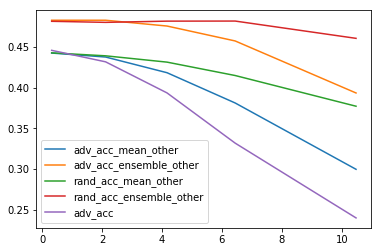

In [33]:
plt.plot(strength, adv_acc_mean_other, label='adv_acc_mean_other')
plt.plot(strength, adv_acc_ensemble_other, label='adv_acc_ensemble_other')
plt.plot(strength, rand_acc_mean_other, label='rand_acc_mean_other')
plt.plot(strength, rand_acc_ensemble_other, label='rand_acc_ensemble_other')
plt.plot(strength, adv_acc, label='adv_acc')
plt.legend()

In [34]:
header=['strength', 'adv_acc', 'adv_acc_mean_other', 'adv_acc_ensemble_other', 'rand_acc_mean_other', 'rand_acc_ensemble_other']
arr = [strength, adv_acc, adv_acc_mean_other, adv_acc_ensemble_other, rand_acc_mean_other, rand_acc_ensemble_other]
log_plot_data(attack_name=attack_name, header=header, arr=arr)